# Main Script For Project Miniblock

## First: Set up the head directory

In [1]:
from pathlib import Path
import sys
from os.path import join
current_path = Path.cwd()

# look through all parents
for parent in current_path.parents:
    if parent.name == "project_miniblock":
        project_dir = parent
        break
else:
    raise FileNotFoundError("Could not find a parent folder named 'project_miniblock'.")

glmdir = project_dir.parent.parent # in my case this is true might not be true for you 
sys.path.append(join(glmdir, 'GLMsingle/python'))
sys.path.append(join(glmdir, 'fracridge/fracridge'))

from preprocessing import get_design_matrices, get_motion_parameters, accuracies_functional, accuracies_localizer
subjects = [f"{i:02d}" for i in range(1,23)]

## Preprocessing

### Create design matrices for GLMSingle

In [ ]:
get_design_matrices(project_dir, subjects)

### Create Plots for motion parameters and check excessive motion

In [ ]:
subjects = ["09"]
get_motion_parameters(project_dir, subjects)

### Get accuracies for functional runs

In [4]:
accuracy_df = accuracies_functional(project_dir, subjects)
localizer_acc_df = accuracies_localizer(project_dir, subjects)

## Run GLM Single

### Functional data

In [ ]:
from preprocessing import glm_single_func
#subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
subjects  = ["09"]
outputs = [0,1,0,1]

glm_single_func(project_dir, subjects, outputs)

### Localizer data

In [ ]:
from preprocessing import glm_single_loc
subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
outputs = [0,1,0,1]

glm_single_loc(project_dir, subjects, outputs)

### Move the files into the GLM directory and rename them

In [ ]:
from os.path import join
import os

output_dir = join(project_dir, "miniblock/Outputs")

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9,16]]
designs = ["er", "sus", "miniblock"]
smooths = ["sm_2_vox", "unsmoothed"]
# make directory 
glm_dir = join(output_dir, "GLMSingle_Outputs")
os.makedirs(glm_dir, exist_ok=True)

for sub in subjects:
    for design in designs:
        for smoothing in smooths:
            # Original file path
            src_path = join(output_dir, f"sub-{sub}",f"{smoothing}_sub-{sub}_{design}", "TYPED_FITHRF_GLMDENOISE_RR.npy")
            
            # New file name
            new_filename = f"{smoothing}_sub-{sub}_{design}_TYPED_FITHRF_GLMDENOISE_RR.npy"
            
            # Destination path
            dst_path = join(glm_dir, new_filename)
            
            # Move & rename
            if os.path.exists(src_path):
                os.rename(src_path, dst_path)
                print(f"Moved: {src_path} -> {dst_path}")
            else:
                print(f"File does not exist: {src_path}")




### Move the files into the GLMSingle localizer directory

In [ ]:
from os.path import join
import os

output_dir = join(project_dir, "miniblock/Outputs")

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9,16]]
designs = ["er", "sus", "miniblock"]
smooths = ["sm_2_vox", "unsmoothed"]
# make directory 
glm_dir = join(output_dir, "GLMSingle_Outputs/localizer")
os.makedirs(glm_dir, exist_ok=True)

for sub in subjects:
    for smoothing in smooths:
        # Original file path
        src_path = join(output_dir, "localizer",f"sub-{sub}",f"{smoothing}_sub-{sub}_localizer", "TYPED_FITHRF_GLMDENOISE_RR.npy")
        
        # New file name
        new_filename = f"{smoothing}_sub-{sub}_TYPED_FITHRF_GLMDENOISE_RR.npy"
        
        # Destination path
        dst_path = join(glm_dir, new_filename)
        
        # Move & rename
        if os.path.exists(src_path):
            os.rename(src_path, dst_path)
            print(f"Moved: {src_path} -> {dst_path}")
        else:
            print(f"File does not exist: {src_path}")




## Masking

### Preparation

#### Unzip JuBrain masks

In [8]:
from masking import unzip_file
import os

maskdir = join(project_dir, "Code/JuBrain_masks")
files = os.listdir(maskdir)
for file in files: 
    if ".gz" in file:
        unzip_file(join(maskdir, file), join(maskdir, file[:-3]))

Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex.nii


#### Resample JuBrain masks

In [9]:
from masking import resample_and_save_mask
import os
maskdir = join(project_dir, "Code/JuBrain_masks")
files = os.listdir(maskdir)
for unzipped_file in files: 
    if ".gz" not in unzipped_file and ".nii" in unzipped_file: 
        resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(maskdir, unzipped_file),
                               output_mask_path=join(maskdir, unzipped_file[:-4]+ "_resampled.nii"))

Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV_resampled.nii


#### Resample fMRIPrep masks

In [21]:
import os
import re

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
whole_brain_mask = re.compile(r'.*space-MNI152NLin2009cAsym_desc-brain_mask\.nii\.gz$')
grey_matter_mask = re.compile(r'.*space-MNI152NLin2009cAsym_label-GM_probseg\.nii\.gz$')

for sub in subjects:
    anatdir = os.path.join(project_dir, f"miniblock/derivatives/sub-{sub}/anat")
    for file in os.listdir(anatdir):
        if whole_brain_mask.match(file):
            whole_brain_file = os.path.abspath(os.path.join(anatdir, file))
            resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(anatdir, whole_brain_file),
                               output_mask_path=join(anatdir, whole_brain_file[:-7]+ "_resampled.nii.gz"))

        elif grey_matter_mask.match(file):
            grey_matter_file = os.path.abspath(os.path.join(anatdir, file))
            resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(anatdir, grey_matter_file),
                               output_mask_path=join(anatdir, grey_matter_file[:-7]+ "_resampled.nii.gz"))


Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-brain_mask_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-02/anat/sub-02_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-02/anat/sub-02_space-MNI152NLin2009cAsym_desc-brain_mask_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-03/anat/sub-03_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-03/anat/sub-03_space-MNI152NLin20

#### Generate Group Mask for Decoding

In [2]:
from masking import get_group_mask

get_group_mask(project_dir=project_dir)

### All ROIs

#### Visually Responsive Voxels

In [3]:
from masking import get_visually_responsive_voxels
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_visually_responsive_voxels(project_dir=project_dir, subjects=subjects)

#### Early Visual Cortex

In [4]:
from masking import get_evc_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_evc_mask(project_dir=project_dir, subjects=subjects)

#### Fusiform Face Area

In [5]:
from masking import get_FFA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_FFA_mask(project_dir=project_dir, subjects=subjects)

Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.
Saved mask.


#### Parahippocampal Place Area

In [6]:
from masking import get_PPA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_PPA_mask(project_dir=project_dir, subjects=subjects)

#### Extrastriate Body Area

In [7]:
from masking import get_EBA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_EBA_mask(project_dir=project_dir, subjects=subjects)

## Reliability

### Get Whole-Brain Maps

In [ ]:
from reliability import get_whole_brain_rel_maps

subjects = [f"{i:02d}" for i in range(1,2) if i not in [9, 16]]
get_whole_brain_rel_maps(project_dir, subjects)

In [2]:
from reliability import gather_reliability_maps
from os.path import exists
import pandas as pd

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]
if exists(join(project_dir, "miniblock/Outputs/reliability/reliability_results_all.csv")):
    results_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/reliability_results_all.csv"))
else: 
    results_df = gather_reliability_maps(project_dir, subjects, ROIs)

#### Quick visualization

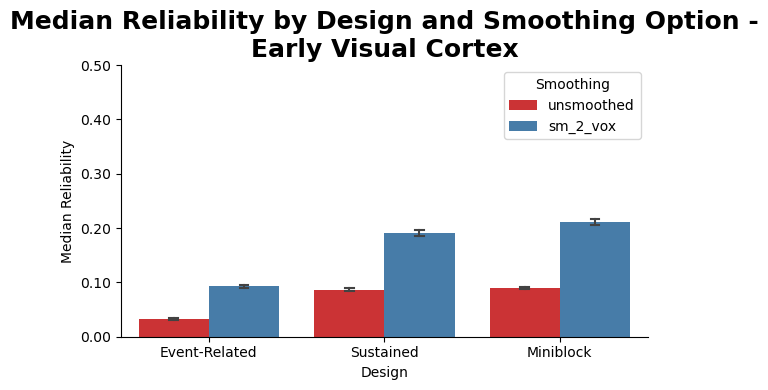

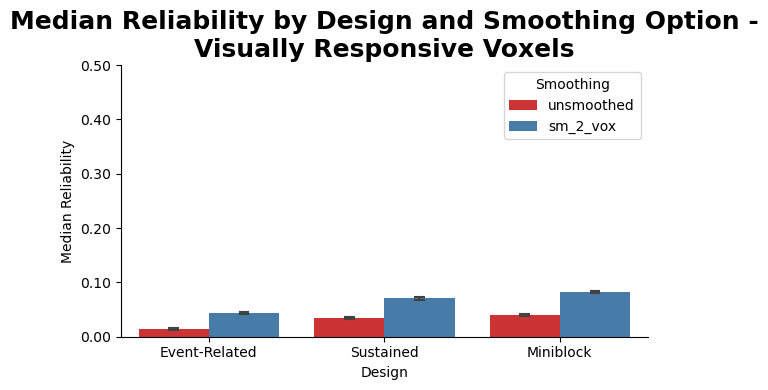

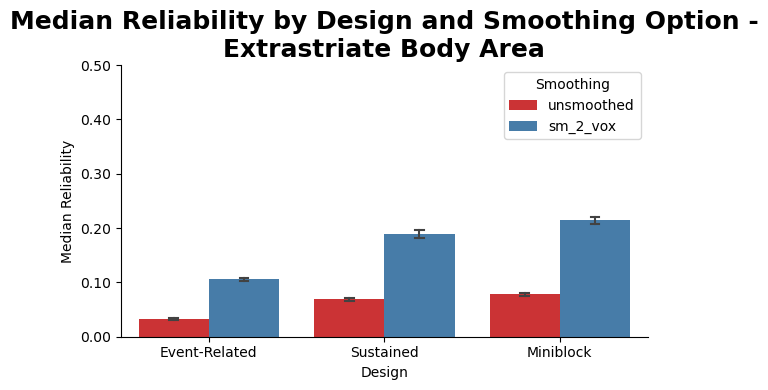

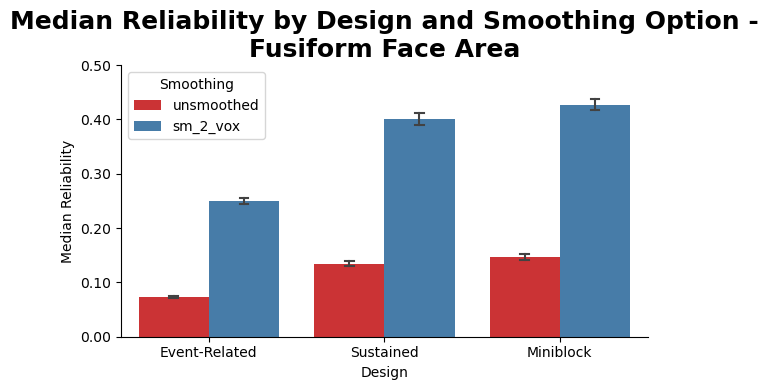

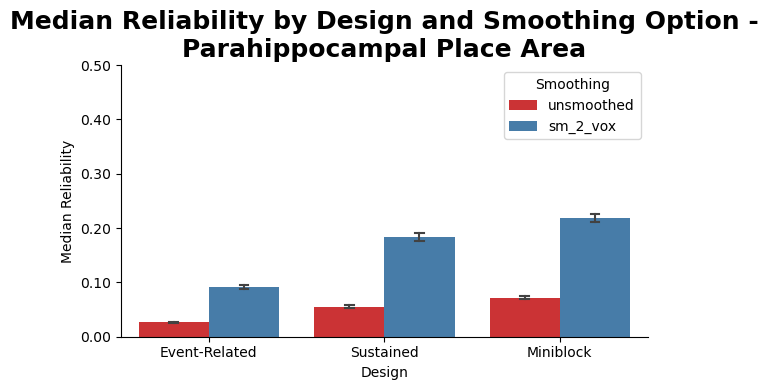

In [3]:
from reliability import make_reliability_plots
make_reliability_plots(results_df)

#### Group results voxel-wise reliability

In [3]:
from reliability import group_results_wholebrain

significance = group_results_wholebrain(results_df)
significance.head(15)

,ROI,smoothing,er_vs_miniblock_p_corrected,er_vs_sus_p_corrected,miniblock_vs_sus_p_corrected
0,visually_responsive_voxels,sm_2_vox,1,1,1
1,visually_responsive_voxels,unsmoothed,1,1,0
2,FFA,sm_2_vox,1,1,0
3,FFA,unsmoothed,1,1,0
4,PPA,sm_2_vox,1,1,1
5,PPA,unsmoothed,1,1,1
6,EBA,sm_2_vox,1,1,0
7,EBA,unsmoothed,1,1,0
8,EVC,sm_2_vox,1,1,0
9,EVC,unsmoothed,1,1,0


### Side Analyses

#### Progression analysis

In [ ]:
from reliability import reliability_progression_between_runs
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

reliability_progression_between_runs(project_dir, subjects)


In [4]:
from os.path import exists
import pandas as pd
from reliability import gather_progession_between

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_between/reliability_progression_between.csv")):
    progression_between_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_between/reliability_progression_between.csv"))
else: 
    progression_between_df = gather_progession_between(project_dir, subjects, ROIs) 


In [ ]:
from reliability import reliability_progression_within_runs
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

reliability_progression_within_runs(project_dir, subjects)

In [2]:
from os.path import exists
import pandas as pd
from reliability import gather_progession_within

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_within/reliability_progression_within.csv")):
    progression_within_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_within/reliability_progression_within.csv"))
else: 
    progression_within_df = gather_progession_within(project_dir, subjects, ROIs) 

##### Progression within visualizations

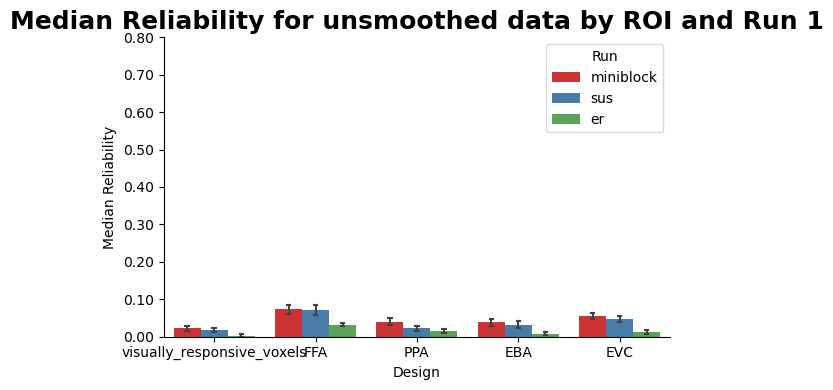

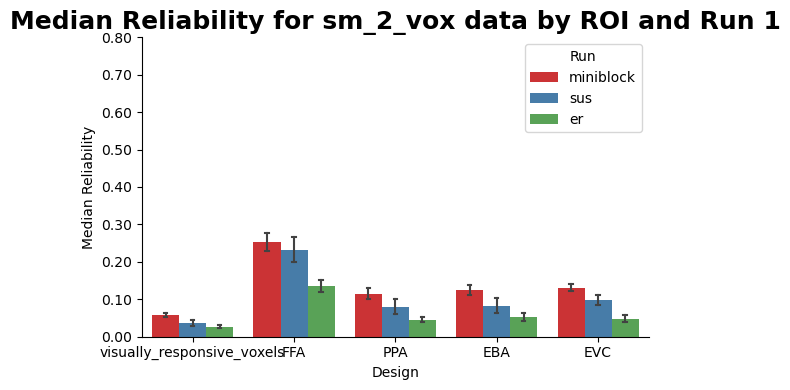

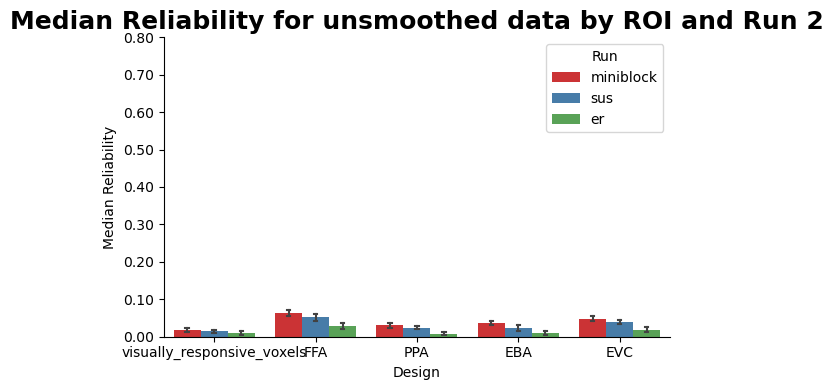

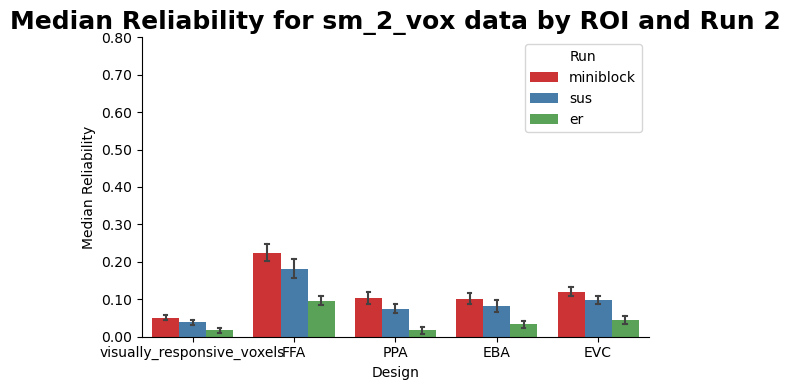

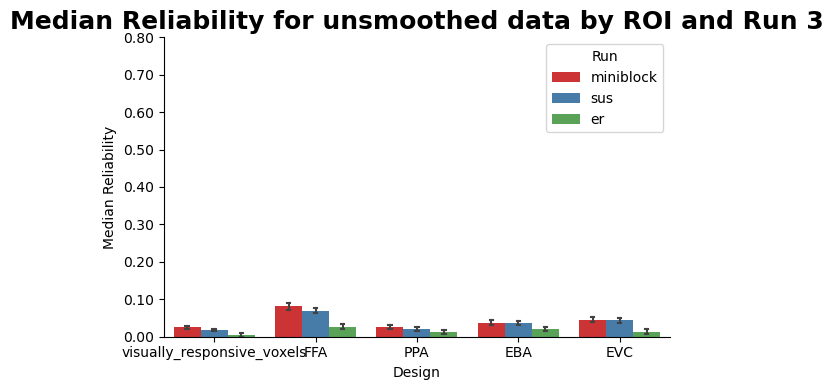

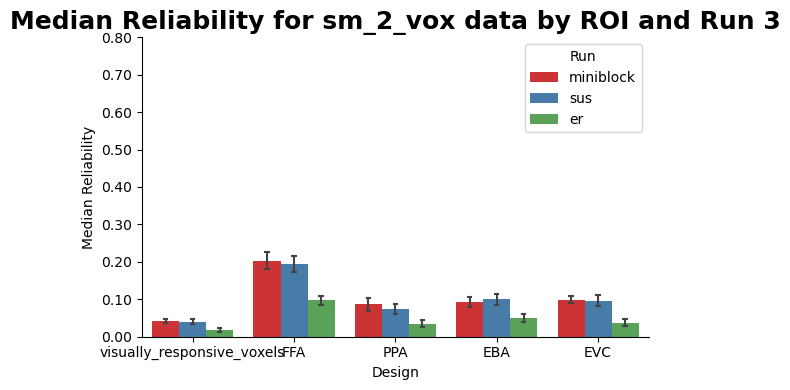

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

smooths = ["unsmoothed", "sm_2_vox"]

# Optional: custom palette
palette = sns.color_palette("Set1")[:3]

ROI_dir = {
    "visually_responsive_voxels": "Visually Responsive Voxels",
    "EVC": "Early Visual Cortex",
    "EBA": "Extrastriate Body Area",
    "FFA": "Fusiform Face Area",
    "PPA": "Parahippocampal Place Area"
}

smoothed_df = progression_within_df[progression_within_df["smoothing"] == "unsmoothed"]

for r in range(1,4):
    for smoothing in smooths:
        
        smoothed_df = progression_within_df[progression_within_df["smoothing"] == smoothing]
        run_df = smoothed_df[smoothed_df["run"] == r]

        g = sns.catplot(
            data=run_df,
            kind="bar",
            x="ROI",
            y="median_rel",
            hue="runtype",
            height=4,
            aspect=1.2,
            palette=palette,
            errorbar="se",
            capsize=0.1,
            err_kws={'linewidth': 1.5}
        )

        # Set y-axis limits and ticks on the main axis
        ax = g.ax
        ax.set_ylim(0, 0.8)  # set min and max y-axis limits, adjust to your needs

        # Optional: format y-axis labels
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

        g.set_titles(f"{r}", size=16, weight="bold")
        g.set_axis_labels("Design", "Median Reliability")
        g.set_xticklabels()
        g._legend.remove()


        plt.title(f"Median Reliability for {smoothing} data by ROI and Run {r}", fontsize=18, fontweight="bold")
        plt.legend(title="Run")
        plt.tight_layout()
        plt.show()


#### Noise Ceiling as in NSD Paper

In [2]:
from reliability import noise_ceilings
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

noise_ceilings(project_dir, subjects)

In [2]:
from reliability import gather_noise_ceilings
from os.path import exists
import pandas as pd

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/noise_ceilings/df_noise_ceilings.csv")):
    noise_ceilings_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/noise_ceilings/df_noise_ceilings.csv"), index_col=0)
else: 
    noise_ceilings_df = gather_noise_ceilings(project_dir, subjects, ROIs) 

##### Group results noise ceiling 

In [ ]:
from reliability import group_results_noise_ceiling

significant_df = group_results_noise_ceiling(noise_ceilings_df)
significant_df.head(15)

,ROI,smoothing,er_vs_miniblock_p_corrected,er_vs_sus_p_corrected,miniblock_vs_sus_p_corrected
0,visually_responsive_voxels,sm_2_vox,1,1,0
1,visually_responsive_voxels,unsmoothed,1,1,0
2,FFA,sm_2_vox,1,1,0
3,FFA,unsmoothed,1,1,0
4,PPA,sm_2_vox,1,0,0
5,PPA,unsmoothed,0,0,0
6,EBA,sm_2_vox,1,1,0
7,EBA,unsmoothed,1,1,0
8,EVC,sm_2_vox,1,1,0
9,EVC,unsmoothed,1,1,0


## Decoding

### Create nifti images for SPM to use in the decoding toolbox

In [2]:
from decoding import create_nifti_betas

subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
create_nifti_betas(project_dir, subjects)

### Get orders for group-based decoding

In [ ]:
# import pandas as pd
# import os
# df_animate = pd.DataFrame({
#     "isanimate": animate
# })
# os.makedirs(join(project_dir,"Behavior/CondRichData/group_decoding"), exist_ok=True)
# df_animate.to_csv(path_or_buf=join(project_dir,"Behavior/CondRichData/group_decoding/df_animate.csv"))

# df_inanimate = pd.DataFrame({
#     "inanimate": inanimate
# })
# df_inanimate.to_csv(path_or_buf=join(project_dir,"Behavior/CondRichData/group_decoding/df_inanimate.csv"))

In [2]:
from decoding import get_orders_by_design
import pandas as pd
animate = pd.read_csv(join(project_dir,"Behavior/CondRichData/group_decoding/df_animate.csv"), index_col=0)
animate = animate[animate["isanimate"] != "oyster"] 
get_orders_by_design(project_dir, animate["isanimate"])

Working on subject 01
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Working on subject 02
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Working on subject 03
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_counter: 10
Animate counter: 10, inanimate_

### Switch to MATLAB for ROI and searchlight decoding

## RSA

### Side Analyses

In [2]:
from RSA import PCA_all_trials, PCA_CV

In [3]:
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["FFA", "PPA", "EBA", "EVC"]
runtypes = ["sus", "miniblock", "er"]

explained_variance = PCA_all_trials(project_dir, subjects, ROIs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
mean_over_part = explained_variance.mean(axis=0)
for runtype in range(3):
    for ROI in range(4):
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(1, 41), mean_over_part[runtype, ROI,:], 'o-', label='Explained variance ratio')
        plt.xlabel('Principal component')
        plt.ylabel('Variance explained')
        plt.title(f'Scree plot of RSM PCA: {runtypes[runtype]} and {ROIs[ROI]}')
        plt.grid(True)
        plt.show()

In [7]:
explained_variance_train, explained_variance_test, _ = PCA_CV(project_dir, subjects, ROIs)

In [ ]:
mean_over_part = explained_variance_test.mean(axis=0)
for runtype in range(3):
    for ROI in range(4):
        for step in range(6):
                plt.figure(figsize=(8,5))
                plt.plot(np.arange(1, 41), mean_over_part[runtype, ROI, step, :], 'o-', label='Explained variance ratio')
                plt.xlabel('Principal component')
                plt.ylabel('Variance explained')
                plt.title(f'Scree plot of RSM PCA: {runtypes[runtype]} and {ROIs[ROI]} and CV-Step {step}')
                plt.grid(True)
                plt.show()